# Model Based Collaborative Filtering Recommender

The goal of the recommender system is to predict user preference for a set of items based on the past experience. Two the most popular approaches are Content-Based and Collaborative Filtering.

Collaborative filtering is a technique used by websites like Amazon, YouTube, and Netflix. It filters out items that a user might like on the basis of reactions of similar users. There are two categories of collaborative filtering algorithms: memory based and model based.

Model based approach involves building machine learning algorithms to predict user's ratings. They involve dimensionality reduction methods that reduce high dimensional matrix containing abundant number of missing values with a much smaller matrix in lower-dimensional space.

The goal of this exercise is to compare SVD and NMF algorithms, try different configurations of parameters and explore obtained results.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from surprise import Dataset, Reader
from surprise import SVD, NMF
from surprise.model_selection import cross_validate, train_test_split, GridSearchCV

import functions as f

This analysis will focus on book recommendations based on [Book-Crossing dataset](http://www2.informatik.uni-freiburg.de/~cziegler/BX/). To reduce the dimensionality of the dataset and avoid running into memory error it will focus on users with at least 3 ratings and top 10% most frequently rated books. It consists of 176,594 records.

The recommender systems will be built using [surprise package](https://surprise.readthedocs.io/en/stable/getting_started.html) (Matrix Factorization - based models).

In [2]:
df = pd.read_csv('data/ratings_top.csv')

reader = Reader(rating_scale=(1, 10))
data = Dataset.load_from_df(df[['user_id', 'isbn', 'book_rating']], reader)

In [3]:
print('Number of ratings: %d\nNumber of books: %d\nNumber of users: %d' % (len(df), len(df['isbn'].unique()), len(df['user_id'].unique())))

Number of ratings: 176594
Number of books: 16766
Number of users: 20149


## SVD and NMF models comparison

Singular Value Decomposition (SVD) and Non-negative Matrix Factorization (NMF) are matrix factorization techniques used for dimensionality reduction. Surprise package provides implementation of those algorithms.

It's clear that for the given dataset much better results can be obtained with SVD approach - both in case of accuracy and training / testing time.

In [15]:
model_svd = SVD()
cv_results_svd = cross_validate(model_svd, data, cv=3)
pd.DataFrame(cv_results_svd).mean()

test_rmse     1.606926
test_mae      1.242338
fit_time     18.130412
test_time     1.120190
dtype: float64

In [16]:
model_nmf = NMF()
cv_results_nmf = cross_validate(model_nmf, data, cv=3)
pd.DataFrame(cv_results_nmf).mean()

test_rmse     2.640803
test_mae      2.255504
fit_time     22.795353
test_time     1.005285
dtype: float64

## Optimisation of SVD algorithm

In [17]:
param_grid = {'n_factors': [80,100,120],
              'n_epochs': [5, 10, 20],
              'lr_all': [0.002, 0.005],
              'reg_all': [0.2, 0.4, 0.6]}

gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=3)
gs.fit(data)

print(gs.best_score['rmse'])
print(gs.best_params['rmse'])

#1.5981785240945765
#{'n_factors': 80, 'n_epochs': 20, 'lr_all': 0.005, 'reg_all': 0.2}

1.5981785240945765
{'n_factors': 80, 'n_epochs': 20, 'lr_all': 0.005, 'reg_all': 0.2}


## Analysis of Collaborative Filtering model results

In [18]:
trainset, testset = train_test_split(data, test_size=0.2)

model = SVD(n_factors=80, n_epochs=20, lr_all=0.005, reg_all=0.2)
model.fit(trainset)
predictions = model.test(testset)

In [23]:
df_pred = pd.DataFrame(predictions, columns=['user_id', 'isbn', 'actual_rating', 'pred_rating', 'details'])

df_pred['impossible'] = df_pred['details'].apply(lambda x: x['was_impossible'])
df_pred['pred_rating_round'] = df_pred['pred_rating'].round()
df_pred['abs_err'] = abs(df_pred['pred_rating'] - df_pred['actual_rating'])
df_pred.drop(['details'], axis=1, inplace=True)

df_pred.sample(5)

,user_id,isbn,actual_rating,pred_rating,impossible,pred_rating_round,abs_err
13497,28373,0552996009,9.0,7.601010,False,8.0,1.398990
31524,271225,0385495641,9.0,7.868930,False,8.0,1.131070
5485,179739,0441172695,9.0,8.193671,False,8.0,0.806329
32172,173999,229030039X,9.0,7.586717,False,8.0,1.413283
12732,93629,0679726012,9.0,7.415487,False,7.0,1.584513


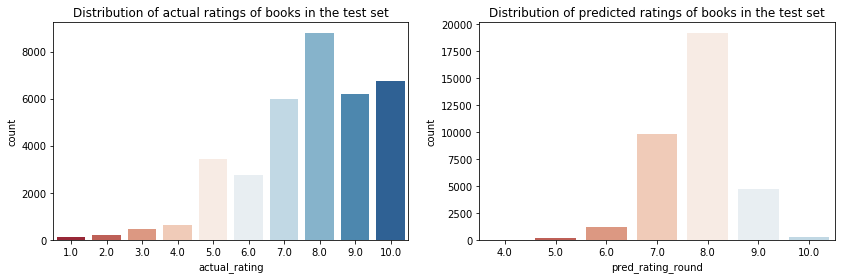

In [20]:
palette = sns.color_palette("RdBu", 10)
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(14, 4))

sns.countplot(x='actual_rating', data=df_pred, palette=palette, ax=ax1)
ax1.set_title('Distribution of actual ratings of books in the test set')

sns.countplot(x='pred_rating_round', data=df_pred, palette=palette, ax=ax2)
ax2.set_title('Distribution of predicted ratings of books in the test set')

plt.show()

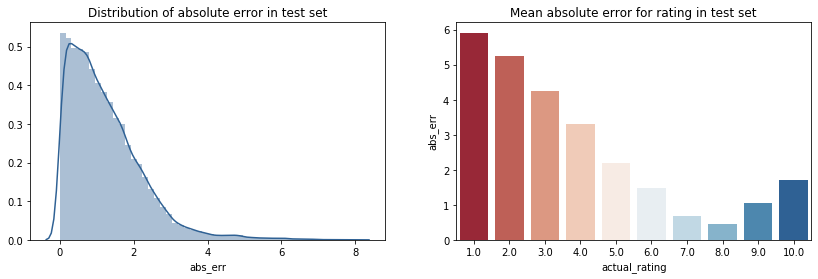

In [21]:
df_pred_err = df_pred.groupby('actual_rating')['abs_err'].mean().reset_index()

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(14, 4))

sns.distplot(df_pred['abs_err'], color='#2f6194', ax=ax1)
ax1.set_title('Distribution of absolute error in test set')

sns.barplot(x='actual_rating', y='abs_err', data=df_pred_err, palette=palette, ax=ax2)
ax2.set_title('Mean absolute error for rating in test set')

plt.show()

In [41]:
df_books = pd.read_csv('data/books.csv')

df_ext = df.merge(df_books[['isbn', 'book_title']], on='isbn', how='left')
df_ext['book_title_short'] = df_ext['book_title'].apply(f.short_title)
df_ext = df_ext.merge(df_pred[['isbn', 'user_id', 'pred_rating']], on=['isbn', 'user_id'], how='left')

In [62]:
selected_user_id = np.random.choice(df_ext['user_id']) #12824
print(selected_user_id)

df_user = df_ext[df_ext['user_id']==selected_user_id]
df_user[df_user['pred_rating'].isna()].sort_values('book_rating', ascending=False).head(15)

12824


,user_id,isbn,book_rating,book_title,book_title_short,pred_rating
11344,12824,193151495X,10,Real Bout High School #1,Real Bout High School #1,NaN
11342,12824,1591824141,10,".Hack: //Legend of the Twilight, Vol. 1",".Hack: //Legend of the Twilight, Vol. 1",NaN
11335,12824,1591820065,10,Chobits VOL. 3,Chobits VOL. 3,NaN
11336,12824,1591820073,10,Chobits (Chobits),Chobits (Chobits),NaN
11324,12824,0671024337,10,The Watchers Guide Buffy The Vampire Slayer (B...,The Watchers Guide Buffy The Vampire Slayer,NaN
11337,12824,1591821533,10,Chobits (Chobits),Chobits (Chobits),NaN
11320,12824,0451092163,10,The Shining (Signet Book),The Shining (Signet Book),NaN
11340,12824,1591822572,10,Chobits (Chobits),Chobits (Chobits),NaN
11316,12824,0439136369,10,Harry Potter and the Prisoner of Azkaban (Book 3),Harry Potter and the Prisoner of Azkaban,NaN
11343,12824,159182415X,10,".Hack: //Legend of the Twilight, Vol. 2",".Hack: //Legend of the Twilight, Vol. 2",NaN


In [65]:
df_user[df_user['pred_rating'].notna()].sort_values('pred_rating', ascending=False).head(5)

,user_id,isbn,book_rating,book_title,book_title_short,pred_rating
11308,12824,0064405028,10,The Voyage of the 'Dawn Treader' (The Chronicl...,The Voyage of the 'Dawn Treader' (The Chronicles,8.395010
11322,12824,0670835382,8,Four Past Midnight,Four Past Midnight,8.385025
11317,12824,0440206154,8,Red Dragon,Red Dragon,8.274115
11312,12824,0345370775,7,Jurassic Park,Jurassic Park,8.111547
11341,12824,1591822580,10,Chobits (Chobits),Chobits (Chobits),8.111333


In [66]:
df_user[df_user['pred_rating'].notna()].sort_values('book_rating', ascending=False).head(5)

,user_id,isbn,book_rating,book_title,book_title_short,pred_rating
11308,12824,0064405028,10,The Voyage of the 'Dawn Treader' (The Chronicl...,The Voyage of the 'Dawn Treader' (The Chronicles,8.395010
11341,12824,1591822580,10,Chobits (Chobits),Chobits (Chobits),8.111333
11333,12824,1568304706,9,Adobe(R) Illustrator(R) 8.0 Classroom in a Book,Adobe(R) Illustrator(R) 8.0 Classroom in,7.894696
11317,12824,0440206154,8,Red Dragon,Red Dragon,8.274115
11321,12824,0553561618,8,Dark Paradise,Dark Paradise,7.449869
